In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
DATA_ROOT = Path('C:/Users/murug/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1')
NUM_CLASSES = 6
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 3
MODEL_NAME = "resnet50" # Options: resnet50, mobilenet_v2, efficientnet_b0
MODELS_TO_TEST = ["resnet50", "mobilenet_v2", "efficientnet_b0"]
BEST_MODEL_PATH = 'best_model.pth'

In [3]:
# --- Data Loading ---
def get_data_loaders(data_root, image_size, batch_size):
    """
    Creates data loaders for the training and validation sets.
    """
    print("\nLoading data from prepared directories...")
    # These transforms should match the ones used in the data prep script for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'validation': transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_root, x), 
            data_transforms[x]
        ) for x in ['train', 'validation']
    }
    
    dataloaders = {
        x: DataLoader(
            image_datasets[x], 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4
        ) for x in ['train', 'validation']
    }
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
    class_names = image_datasets['train'].classes
    
    print("Data loaders created successfully.")
    return dataloaders, dataset_sizes, class_names

In [4]:
# --- Model Development (Transfer Learning) ---
def build_model(model_name, num_classes):
    """
    Loads a pre-trained model, freezes base layers, and adds a custom classifier.
    """
    print(f"\nBuilding model with {model_name}...")
    if model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # Freeze all layers in the pre-trained model
        for param in model.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer (fc)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer (classifier)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer (classifier)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError("Unsupported model name.")

    print("Model built successfully with a custom classifier.")
    return model

In [5]:
# --- Training and Validation Loop ---
def train_model(model, dataloaders, dataset_sizes, num_epochs, learning_rate):
    """
    The main function for training and validating the model.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    # The optimizer is now defined to only optimize the parameters of the final layer
    # which is either model.fc or model.classifier[1] depending on the model.
    # This assumes the custom classifier is the only part with requires_grad=True
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    
    print("\nStarting training...")
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print("\nTraining complete!")
    return model

In [6]:
# --- Model Evaluation ---
def evaluate_model(model, dataloaders, class_names):
    """
    Evaluates the trained model on the validation set and displays key metrics.
    
    Returns:
        float: The macro F1-score.
    """
    print("\nStarting model evaluation on the validation set...")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval() # Set model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # The following code block was out of the function scope, causing the NameError.
    # It has now been correctly indented.
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Generate and visualize the confusion matrix
    print("\nGenerating confusion matrix...")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Return the macro F1-score for model comparison
    return report['macro avg']['f1-score']


Loading data from prepared directories...
Data loaders created successfully.

--- Starting process for model: resnet50 ---

Building model with resnet50...
Model built successfully with a custom classifier.

Starting training...
Epoch 1/3
----------
train Loss: 1.1319 Acc: 0.6466
validation Loss: 0.7826 Acc: 0.7937
Epoch 2/3
----------
train Loss: 0.6982 Acc: 0.8204
validation Loss: 0.5865 Acc: 0.8313
Epoch 3/3
----------
train Loss: 0.5547 Acc: 0.8555
validation Loss: 0.4986 Acc: 0.8458

Training complete!

Starting model evaluation on the validation set...

Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.83      0.91        81
       glass       0.74      0.84      0.79       101
       metal       0.79      0.91      0.85        82
       paper       0.86      0.95      0.90       119
     plastic       0.92      0.68      0.78        97

    accuracy                           0.85       480
   macro avg       0.86      0

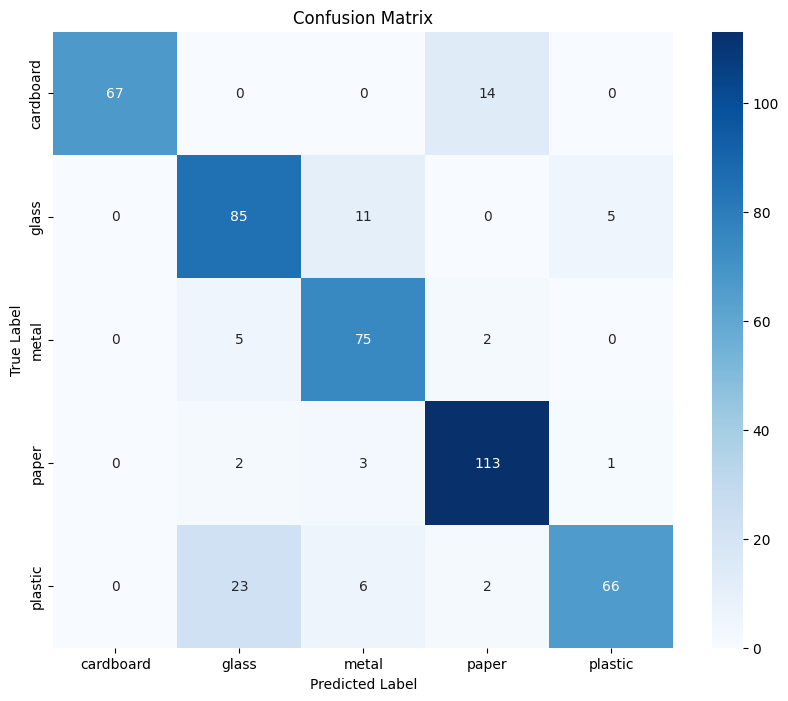


--- Starting process for model: mobilenet_v2 ---

Building model with mobilenet_v2...
Model built successfully with a custom classifier.

Starting training...
Epoch 1/3
----------
train Loss: 1.1564 Acc: 0.6236
validation Loss: 0.8354 Acc: 0.7771
Epoch 2/3
----------
train Loss: 0.7525 Acc: 0.7696
validation Loss: 0.6606 Acc: 0.7979
Epoch 3/3
----------
train Loss: 0.6175 Acc: 0.8126
validation Loss: 0.5793 Acc: 0.8229

Training complete!

Starting model evaluation on the validation set...

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.94      0.84      0.89        81
       glass       0.77      0.73      0.75       101
       metal       0.75      0.84      0.79        82
       paper       0.87      0.88      0.88       119
     plastic       0.80      0.81      0.81        97

    accuracy                           0.82       480
   macro avg       0.83      0.82      0.82       480
weighted avg       0.83      0.82      0.82   

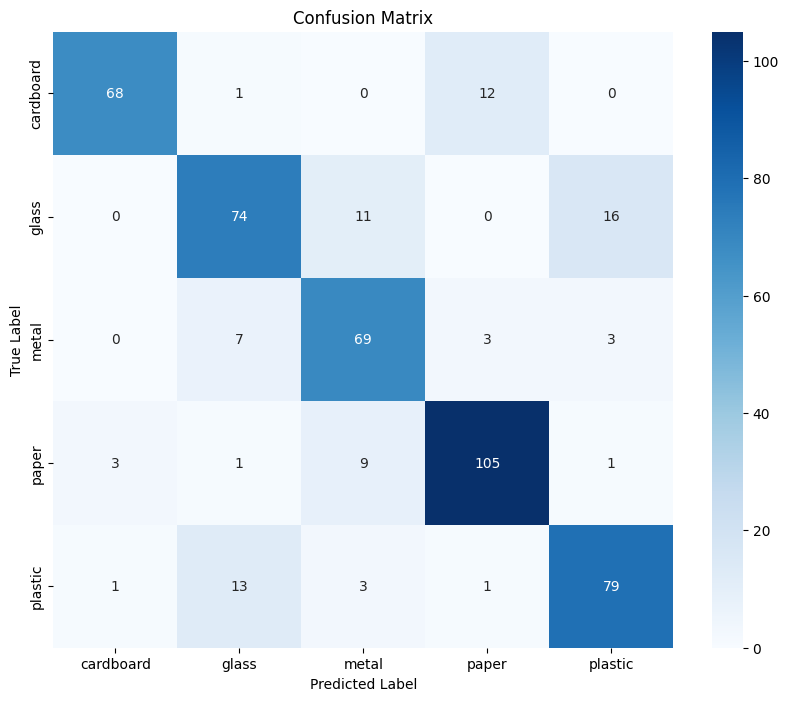


--- Starting process for model: efficientnet_b0 ---

Building model with efficientnet_b0...
Model built successfully with a custom classifier.

Starting training...
Epoch 1/3
----------
train Loss: 1.1044 Acc: 0.6377
validation Loss: 0.7725 Acc: 0.7688
Epoch 2/3
----------
train Loss: 0.7132 Acc: 0.7838
validation Loss: 0.6235 Acc: 0.8021
Epoch 3/3
----------
train Loss: 0.6077 Acc: 0.7974
validation Loss: 0.5768 Acc: 0.8000

Training complete!

Starting model evaluation on the validation set...

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.96      0.83      0.89        81
       glass       0.71      0.77      0.74       101
       metal       0.73      0.84      0.78        82
       paper       0.83      0.83      0.83       119
     plastic       0.83      0.73      0.78        97

    accuracy                           0.80       480
   macro avg       0.81      0.80      0.80       480
weighted avg       0.81      0.80      0

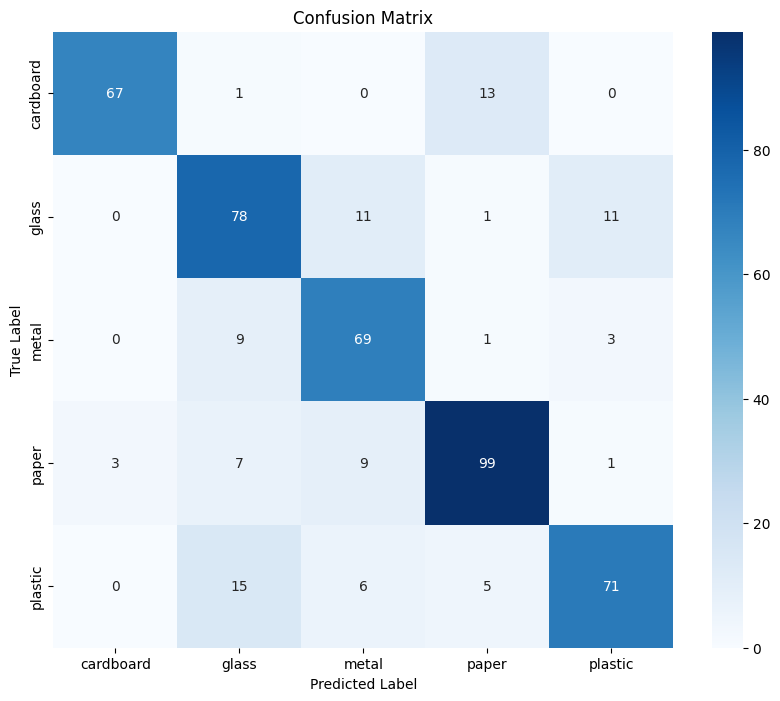


--- Final Model Comparison ---
Model: resnet50        F1-Score: 0.8450
Model: mobilenet_v2    F1-Score: 0.8229
Model: efficientnet_b0 F1-Score: 0.8029

Best Model: resnet50 with an F1-Score of 0.8450
Saving the best model to best_model.pth...
An error occurred: 'resnet50'


In [7]:
# --- Script Execution ---
if __name__ == '__main__':
    try:
        # Get data loaders and class names
        dataloaders, dataset_sizes, class_names = get_data_loaders(DATA_ROOT, IMAGE_SIZE, BATCH_SIZE)
        
        # Dynamically set NUM_CLASSES based on the loaded dataset
        NUM_CLASSES = len(class_names)
        
        best_f1_score = -1.0
        best_model_name = ""
        results = {}
        trained_models = {}

        # Loop through each model to build, train, and evaluate
        for model_name in MODELS_TO_TEST:
            print(f"\n--- Starting process for model: {model_name} ---")
            
            model_ft = build_model(model_name, NUM_CLASSES)
            model_ft = train_model(model_ft, dataloaders, dataset_sizes, NUM_EPOCHS, LEARNING_RATE)
            f1_score = evaluate_model(model_ft, dataloaders, class_names)
            
            results[model_name] = f1_score
            
            # Check if this model is the new best
            if f1_score > best_f1_score:
                best_f1_score = f1_score
                best_model_name = model_name
        
        # Print final summary of all model F1-scores
        print("\n--- Final Model Comparison ---")
        for model_name, f1 in results.items():
            print(f"Model: {model_name:<15} F1-Score: {f1:.4f}")
        
        print(f"\nBest Model: {best_model_name} with an F1-Score of {best_f1_score:.4f}")

        print(f"Saving the best model to {BEST_MODEL_PATH}...")
        best_model_to_save = trained_models[best_model_name]
        torch.save(best_model_to_save.state_dict(), BEST_MODEL_PATH)
        print("Model saved successfully. You can now run the Streamlit app.")
        
    except Exception as e:
        print(f"An error occurred: {e}")

In [8]:
best_model = models.resnet50(pretrained=True)
torch.save(best_model.state_dict(), 'best_model.pth')

c:\Users\murug\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\murug\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\murug/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:03<00:00, 26.4MB/s]
